In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
torch.cuda.set_device(0)

## Data

### Setup

In [3]:
PATH = Path('data/carvana')
list(PATH.iterdir())

[PosixPath('data/carvana/train_masks.zip'),
 PosixPath('data/carvana/train_masks'),
 PosixPath('data/carvana/train.zip'),
 PosixPath('data/carvana/train'),
 PosixPath('data/carvana/train_masks.csv'),
 PosixPath('data/carvana/metadata.csv')]

In [0]:
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'

In [5]:
masks_csv = pd.read_csv(PATH/MASKS_FN)
masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [6]:
meta_csv = pd.read_csv(PATH/META_FN)
meta_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [0]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [0]:
CAR_ID = '00087a6bd4dc'

In [9]:
list((PATH/TRAIN_DN).iterdir())[:5]

[PosixPath('data/carvana/train/351c583eabd6_14.jpg'),
 PosixPath('data/carvana/train/4f1f065d78ac_01.jpg'),
 PosixPath('data/carvana/train/9dfaeb835626_12.jpg'),
 PosixPath('data/carvana/train/9d8c465a0881_13.jpg'),
 PosixPath('data/carvana/train/a4551c5409e3_14.jpg')]

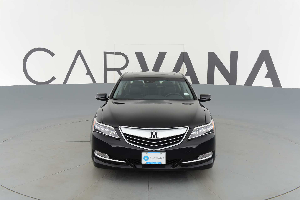

In [10]:
Image.open(PATH/TRAIN_DN/f'{CAR_ID}_01.jpg').resize((300,200))

In [0]:
list((PATH/MASKS_DN).iterdir())[:5]

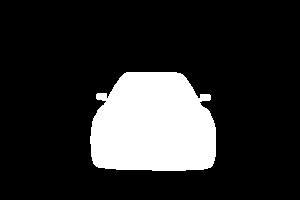

In [11]:
Image.open(PATH/MASKS_DN/f'{CAR_ID}_01_mask.gif').resize((300,200))

In [0]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

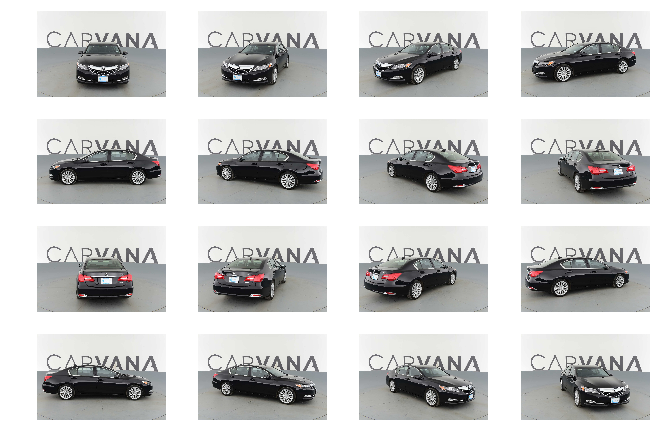

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

### Resize and convert

In [0]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

In [0]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')

In [0]:
files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

In [0]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [0]:
def resize_mask(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks_png').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [0]:
(PATH/'train-128').mkdir(exist_ok=True)

In [0]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

## Dataset

In [0]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64

In [0]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]
im_masks = [open_image(PATH/MASKS_DN/f'{CAR_ID}_{i+1:02d}_mask.png') for i in range(16)]

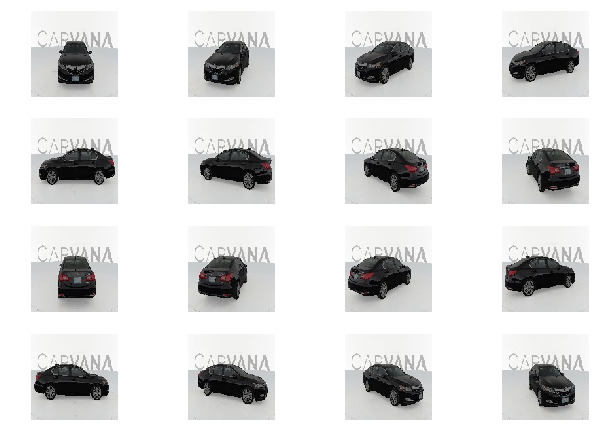

In [28]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [0]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [0]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [31]:
len(x_names)//16//5*16

1008

In [32]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [0]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]
# aug_tfms = []

In [0]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [0]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

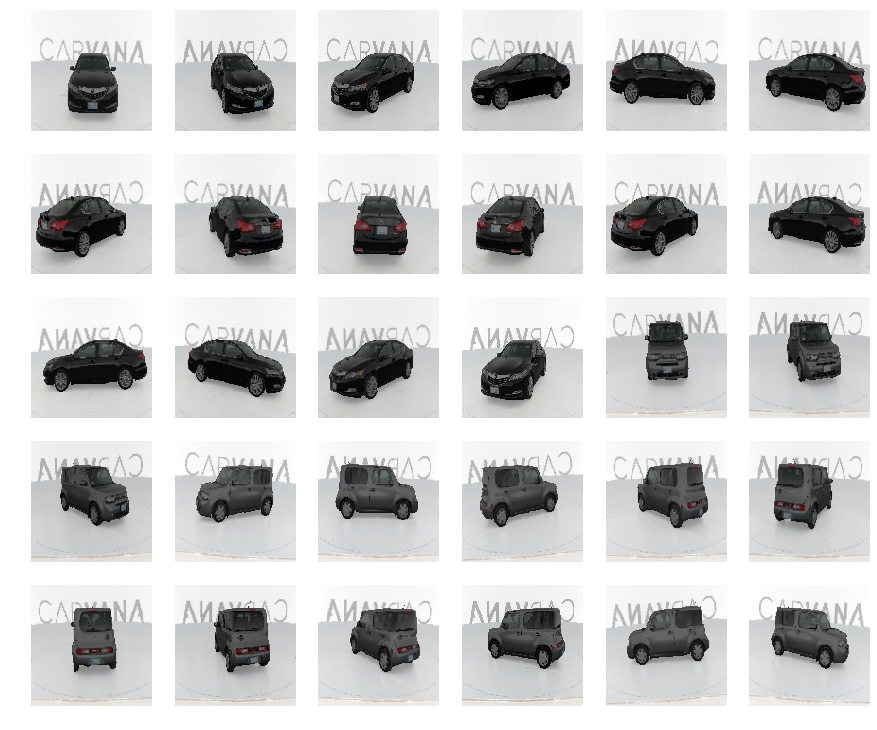

In [36]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

## Model

In [0]:
class Empty(nn.Module): 
    def forward(self,x): return x

models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
learn.summary()

In [0]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [0]:
flatten_channel = Lambda(lambda x: x[:,0])

In [0]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [0]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

Widget Javascript not detected.  It may not be installed or enabled properly.


 88%|████████▊ | 56/64 [00:20<00:02,  3.13it/s, loss=6.92]

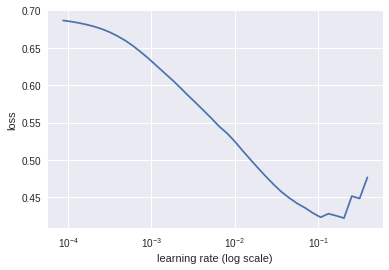

In [42]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr=4e-2

In [44]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   <lambda>   
    0      0.177449   0.163044   0.936401  
    1      0.126754   0.119174   0.94436   
    2      0.105338   0.108444   0.949195  
    3      0.093908   0.094675   0.956518  
    4      0.085331   0.088095   0.960426  


[array([0.0881]), 0.960425905765049]

In [0]:
learn.save('tmp')

In [0]:
learn.load('tmp')

In [0]:
py,ay = learn.predict_with_targs()

In [48]:
ay.shape

(1008, 128, 128)

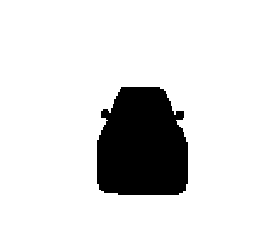

In [49]:
show_img(ay[0]);

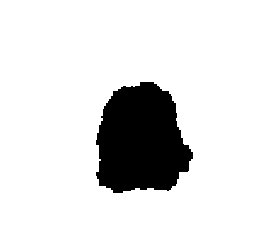

In [50]:
show_img(py[0]>0);

In [0]:
learn.unfreeze()

In [0]:
learn.bn_freeze(True)

In [0]:
lrs = np.array([lr/100,lr/10,lr])/4

In [54]:
learn.fit(lrs,1,cycle_len=20,use_clr=(20,10))

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   <lambda>   
    0      0.086575   0.10375    0.960078  
    1      0.058972   0.042036   0.980342  
    2      0.042793   0.036545   0.983352  
    3      0.034992   0.035135   0.983206  
    4      0.030745   0.031597   0.986743  
    5      0.028384   0.029342   0.987358  
    6      0.027204   0.027528   0.988227  
    7      0.025078   0.02612    0.98876   
    8      0.02393    0.025659   0.989622  
    9      0.022714   0.024869   0.989509  
    10     0.02185    0.024131   0.990176  
    11     0.021204   0.023388   0.990314  
    12     0.020575   0.024046   0.989485  
    13     0.019896   0.023058   0.990775  
    14     0.019141   0.022765   0.991066  
    15     0.018627   0.0224     0.991052  
    16     0.018071   0.021953   0.991374  
    17     0.017574   0.021704   0.991289  
    18     0.017128   0.021461   0.991422  
    19     0.016797   0.021344   0.991492  


[array([0.02134]), 0.991492317782508]

In [0]:
learn.save('0')

In [0]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

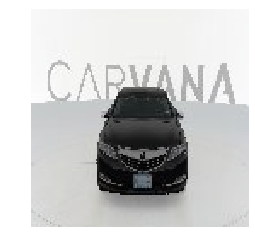

In [57]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

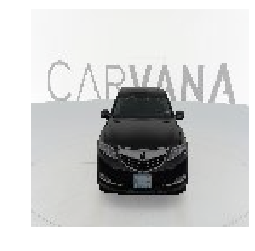

In [58]:
ax = show_img(denorm(x)[0])
show_img(y[0], ax=ax, alpha=0.5);

## 512x512

In [0]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 512
bs = 16

In [0]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [61]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [0]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [0]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

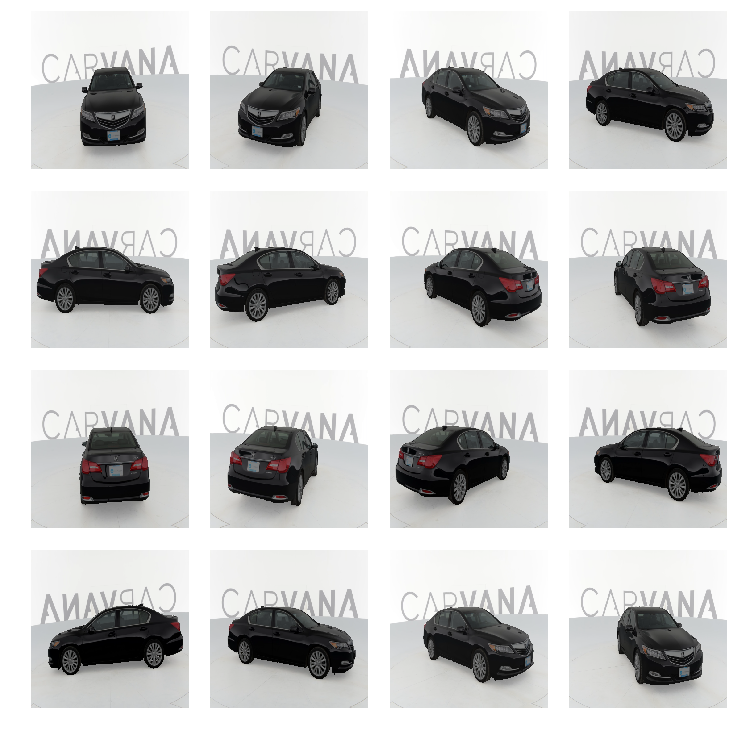

In [64]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [0]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [0]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [0]:
learn.load('0')

Widget Javascript not detected.  It may not be installed or enabled properly.


 85%|████████▍ | 216/255 [07:00<00:56,  1.45s/it, loss=0.524] 

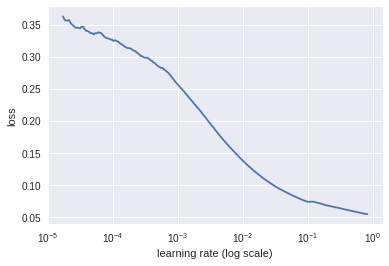

In [68]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr=4e-2

In [70]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   <lambda>   
    0      0.021468   0.020246   0.991883  
    1      0.017607   0.017988   0.993195  
    2      0.016166   0.015793   0.993074  
    3      0.015363   0.017222   0.991736  
    4      0.014431   0.014557   0.993755  


[array([0.01456]), 0.9937553632827032]

In [0]:
learn.save('tmp')

In [0]:
learn.load('tmp')

In [0]:
learn.unfreeze()
learn.bn_freeze(True)

In [0]:
lrs = np.array([lr/100,lr/10,lr])/4

In [75]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   <lambda>   
    0      0.392358   0.509826   0.793212  
    1      0.079372   0.042025   0.980795  
    2      0.027837   0.02714    0.987635  
    3      0.020941   0.020259   0.991642  
    4      0.018911   0.018752   0.992423  
    5      0.017131   0.01788    0.993063  
    6      0.016113   0.016679   0.993073  
    7      0.015468   0.01624    0.993519  


[array([0.01624]), 0.9935187460884215]

In [0]:
learn.save('512')

In [0]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

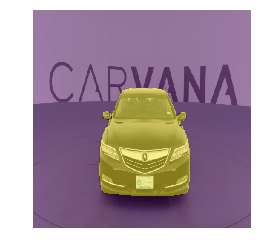

In [0]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

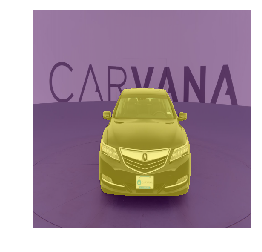

In [0]:
ax = show_img(denorm(x)[0])
show_img(y[0], ax=ax, alpha=0.5);

## 1024x1024

In [0]:
sz = 1024
bs = 4

In [0]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [0]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = to_np(y)

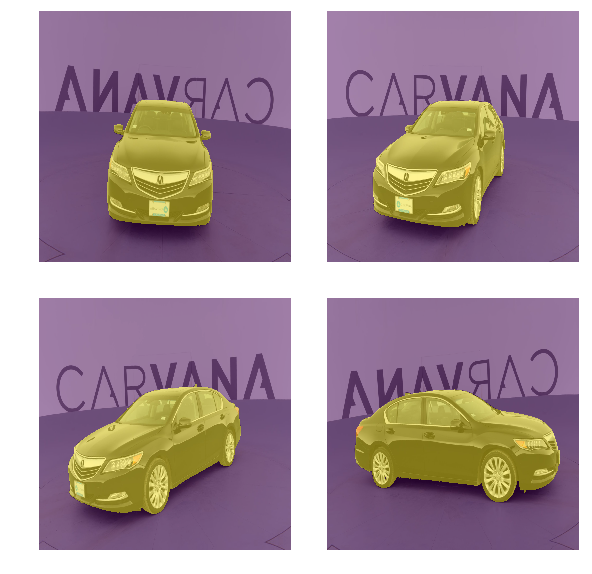

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i,ax in enumerate(axes.flat):
    show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [0]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel,
)

In [0]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [0]:
learn.load('512')

A Jupyter Widget

 85%|████████▌ | 218/255 [02:12<00:22,  1.64it/s, loss=8.91] 

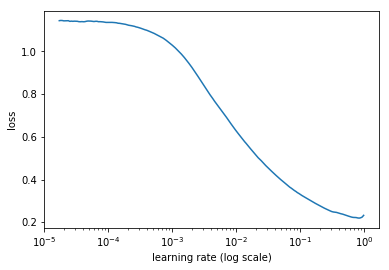

In [0]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr=4e-2

In [0]:
learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

A Jupyter Widget

epoch      trn_loss   val_loss   <lambda>                       
    0      0.01066    0.011119   0.996227  
    1      0.009357   0.009696   0.996553                        



[0.0096957013, 0.99655332546385511]

In [0]:
learn.save('tmp')

In [0]:
learn.load('tmp')

In [0]:
learn.unfreeze()
learn.bn_freeze(True)

In [0]:
lrs = np.array([lr/100,lr/10,lr])/8

In [0]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc                       
    0      0.015565   0.007449   0.997661  
    1      0.01979    0.008376   0.997542                       
    2      0.014874   0.007826   0.997736                       
    3      0.016104   0.007854   0.997347                       
    4      0.023386   0.009745   0.997218                       
    5      0.018972   0.008453   0.997588                       
    6      0.013184   0.007612   0.997588                       
    7      0.010686   0.006775   0.997688                       
    8      0.0293     0.015299   0.995782                       
    9      0.018713   0.00763    0.997638                       
    10     0.015432   0.006575   0.9978                         
    11     0.110205   0.060062   0.979043                      
    12     0.014374   0.007753   0.997451                       
    13     0.022286   0.010282   0.997587                       
    14     0.015645   0.00739    0.997776      

[0.0056782686, 0.99817223208291195]

In [0]:
learn.save('1024')

In [0]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

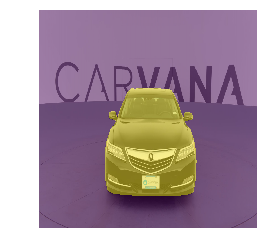

In [0]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

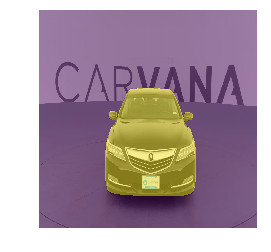

In [0]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

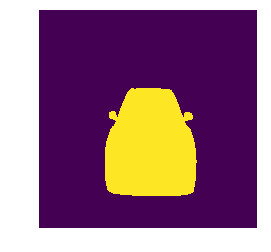

In [0]:
show_img(py[0][0]>0);

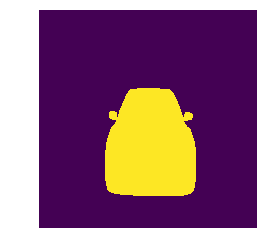

In [0]:
show_img(y[0,...,-1]);

## Fin